# Сравнение трудоёмкости алгоритмов поисков на графах
Выполнил Безлепский Александр Дмитриевич, гр. 5
>* **DFS** - Depth-First Search - Поиск в глубину**
>* **BFS** - Breadth-First Search - Поиск в ширину**

https://arxiv.org/abs/2111.07345

Другими словами, измерение безразмерной величины $\cfrac{\Theta_{DFS}}{\Theta_{BFS}} = \Large\psi$

> В качестве среды разработки используем интерактивные блокноты [Jupyter<base target="_blank">](https://jupyter.org/), код написан на языке [Julia <base target="_blank">](https://julialang.org/) и выполнен паралленьно на 16 ядрах процессора.

## Что будем делать?

Генерация случайного графа оказалась нетривиальной задачей. Чтобы как-то ограничить исследование, предлагаю следующие шаги:
1. Напишем алгоритмы поиска;
2. Разберёмся с используемыми инструментами;
3. Формализуем алгоритмы генерации графов и проведём на них вычислительные эксперименты;

>### Отступление
>Человек ленив. Там, где можно немного упростить себе жизнь, это будет сделано. С этой целью было создано множество высокоуровневых языков программирования, Julia - один из таких. В её экосистеме написано множество библиотек, где описываются графы и вводятся распространённые алгоритмы на них.
>
>Человек ленив, студент - тоже человек, но некотоыре вещи стоит написать самому: используя готовые алгоритмы обхода и пытаясь подстроить их под свои нужды можно набить немало шишек. В библиотеке `Graphs.jl` именно поиски с подсчётом шагов и списком посещённых узлов отсутствуют, вместо них тут различные алгоритмы используют генераторы орграфов. В попытках подстроить эти генераторы под себя студент теряет время и удаляется от сути предмета в сторону хакинга и написания костылей.
## Содержание:
1. [Алгоритмы поиска](#1.-Алгоритмы-поиска)
2. [Инструменты](#2.-Инструменты)
3. [Вычислительные эксперименты](#3.-Эксперименты)
    1. [Dorogovtsev and Mendes](#3.1-Dorogovtsev-and-Mendes)
    2. [Erdős–Rényi](#3.2-Erdős-Rényi)
    3. [Регулярный граф](#3.3-Регулярный-граф)
    4. [Однородные деревья](#3.4-Однородные-(uniform)-деревья)
    5. [Бинарные деревья](#3.5-Бинарные-деревья)
4. [Заключение](#4.-Заключение)
---
## 1. Алгоритмы поиска
Сначала напишем сами алгоритмы поиска в ширину и глубину. По сути своей, это один и тот же алгоритм, реализованный на двух разных структурах данных: **стек** для поиска в глубину и **очередь** для поиска в ширину. И то и другое нам отлично заменит стандартный Vector:

In [2]:
# Вернёт пройденный маршрут
function findpath(p!, graph, a, b)
    visited = falses(length(graph.fadjlist))
    parent = fill(-1, length(graph.fadjlist))
    dataStructure = Int64[]
    push!(dataStructure, a)
    visited[a] = true
    while !isempty(dataStructure)
        curr_node = p!(dataStructure)             # <--- Сюда подставится нужная функция
        for neighbor in graph.fadjlist[curr_node]
            if !visited[neighbor]
                visited[neighbor] = true
                parent[neighbor] = curr_node
                push!(dataStructure, neighbor)
            end
        end
        if curr_node == b
            path = [b]
            while path[end] != a
                push!(path, parent[path[end]])
            end
            return reverse(path)
        end
    end
    return Int64[]
end

# Подставляя в 9-ю строчку выше нужную функцию удаления
# последнего или первого элемента добиваемся желаемого
dfs_path(graph, a, b) = findpath(pop!,      graph, a, b) 
bfs_path(graph, a, b) = findpath(popfirst!, graph, a, b)

bfs_path (generic function with 1 method)

In [3]:
# Перепишем для подсчёта количества шагов (уменьшим аллокации => увеличим быстродействие)
function countsteps(p!, graph, a, b)
    visited = falses(length(graph.fadjlist))
    parent = fill(-1, length(graph.fadjlist))
    dataStructure = Int64[]
    push!(dataStructure, a)
    visited[a] = true
    while !isempty(dataStructure)
        curr_node = p!(dataStructure)
        for neighbor in graph.fadjlist[curr_node]
            if !visited[neighbor]
                visited[neighbor] = true
                parent[neighbor] = curr_node
                push!(dataStructure, neighbor)
            end
        end
        if curr_node == b
            nsteps = 0                           # <--- Отличия
            while curr_node != a                 # <--- от
                curr_node = parent[curr_node]    # <--- предыдущей
                nsteps += 1                      # <--- функции
            end                                  # <--- в
            return nsteps                        # <--- этих
        end
    end
    return -1                                    # <--- строках
end

dfs_steps(graph, a, b) = countsteps(pop!,      graph, a, b) 
bfs_steps(graph, a, b) = countsteps(popfirst!, graph, a, b);

Примечание: в ячейке выше используются два эквивалентных синтаксиса задания функции.

## 2. Инструменты
[К содержанию](#Содержание:)

Ниже приведены библиотеки языка Julia, которые нам понадобятся в процессе работы:
* Библиотека для генерации различных графов
* Библиотеки рисования схем графов и графиков для отрисовки статистики

In [4]:
using Graphs
using GraphPlot
using Colors
using Plots
using PlotThemes
using ThreadsX
using ProgressMeter
using LaTeXStrings;

### Небольшой пример
Простенький демонстрационный граф, который предоставляет сама библиотека 

In [5]:
# Обернём библиотечную функцию для упрощения дальшейших вызовов:
function plot_graph(graph)
    # Все аргументы рисовалки более-менее самообъясняющие:
    gplot(   
        graph,
        nodefillc = "black",
        nodelabel = 1:nv(graph),
        nodelabelc = "white",
        edgestrokec = "darkgray",
    )
end;

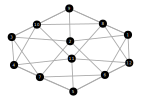

In [6]:
# Здесь `:icosahedral` это значение-лейбл, служащее аргументом функции отрисовки
sample = smallgraph(:icosahedral)

plot_graph(sample)

Получим списки посещённых вершин и их длины (без учёта стартовых):

In [7]:
@show dfs_steps(sample, 1, 10)
dfs_path(sample, 1, 10)

dfs_steps(sample, 1, 10) = 3


4-element Vector{Int64}:
  1
 12
 11
 10

In [8]:
@show bfs_steps(sample, 1, 10)
bfs_path(sample, 1, 10)

bfs_steps(sample, 1, 10) = 2


3-element Vector{Int64}:
  1
  8
 10

Обернём функции выше в ещё одну - которая и будет возвращать искомую величину $\Large\psi$ для всего графа:

In [9]:
function ψᵢ_sum(graph)
    breadth = depth = 0
    for i in 1:nv(graph)
        for j in i+1:nv(graph)
            breadth_steps = bfs_steps(graph, i, j)
            if breadth_steps == -1
                continue
            end
            breadth += breadth_steps
            depth += dfs_steps(graph, i, j)
        end
    end
    return depth/breadth
end;

Покажем работу алгоритма на графе из примера:

In [52]:
@time ψᵢ_sum(sample)

  0.000160 seconds (726 allocations: 72.906 KiB)


1.2592592592592593

Отлично, первый результат получен! Конечно, можно и дальше оптимизировать алгоритм, но, в угоду простоте прототипирования, мы опустим сейчас какие-либо оптимизации, даже не будем аннотировать функции именами типов. Несмотря на это Julia может быть действительно эффективной, приближаясь по производительности к таким компилируемым языкам как C и Fortran. 

---
Перейдём, наконец, к объявленному вычислительному эксперименту. В пакете [Graphs.jl <base target="_blank">](https://juliagraphs.org/Graphs.jl/dev/) есть несколько алгоритмов генерации графов. Наперёд оценить, несколько один предпочтительнее другого не представляется возможным, так что попробуем несколько...

## 3. Эксперименты

[К содержанию](#Содержание:)

### 3.1 [Dorogovtsev and Mendes<base target="_blank">](https://graphstream-project.org/doc/Generators/Dorogovtsev-Mendes-generator/)
Вот как он описан в документации пакета:

>`dorogovtsev_mendes(n)`
>
>Generate a random `n` vertex graph by the Dorogovtsev-Mendes method (with `n ≥ 3`).
>
>The Dorogovtsev-Mendes process begins with a triangle graph and inserts `n-3` additional vertices. Each time a vertex is added, a random edge is selected and the new vertex is connected to the two endpoints of the chosen edge. This creates graphs with many triangles and a high local clustering coefficient.
>
> <...>
>### References
>
  >* http://graphstream-project.org/doc/Generators/Dorogovtsev-Mendes-generator/
  >* https://arxiv.org/pdf/cond-mat/0106144.pdf#page=24

Как видим, этот генератор имеет всего один параметр - количество узлов. Посмотрим, что он генерирует:

In [109]:
dmPlot(g) = gplot(g, nodefillc = "#546ea1", edgestrokec = "darkgray");

ψᵢ_sum(dm1) = 1.2463768115942029
  0.000502 seconds (2.17 k allocations: 248.500 KiB)


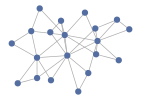

In [110]:
dm1 = dorogovtsev_mendes(20)
@time @show ψᵢ_sum(dm1)
dmPlot(dm1)

ψᵢ_sum(dm2) = 1.3602136181575435
  0.004089 seconds (14.76 k allocations: 2.949 MiB)


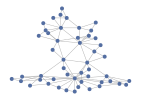

In [111]:
dm2 = dorogovtsev_mendes(50)
@time @show ψᵢ_sum(dm2)
dmPlot(dm2)

ψᵢ_sum(dm3) = 1.4825215785336519
  3.590139 seconds (1.83 M allocations: 2.069 GiB, 13.44% gc time)


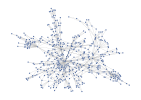

In [112]:
dm3 = dorogovtsev_mendes(500)
@time @show ψᵢ_sum(dm3)
dmPlot(dm3)

Замечу, что во всех достаточно больших сгенерированных графах (выше лишь несколько примеров) есть вершины с относительно высокой степенью (назовём их `центры`). Похоже, они - естественное следствие работы генератора: чем больше рёбер смежно с вершиной, тем вероятнее, что при следующем шаге генератора, на одну из них выпадет стать смежной новой вершине, а значит, степень такого `центра` снова повысится.

In [15]:
function d_m_tests(nspace, repeats)
    n = length(nspace)
    results = zeros(n)
    progress = Progress(n+1, 1)
    next!(progress)
    for i in n:-1:1 # Количество вершин в обратном порядке
        av = zeros(Float32, repeats)
        Threads.@threads for j = 1:repeats # Количество повторений для усреднения
            g = dorogovtsev_mendes(nspace[i]) # новый случайный граф на каждом шаге
            av[j] = ψᵢ_sum(g)
        end
        results[i] = ThreadsX.sum(av)/repeats
        next!(progress)
    end
    return results
end;

In [16]:
logspace(
    start::Real,
    stop::Real,
    len=50,
    base=10
    ) = base.^range(start, stop, len)

logspace(
    T::DataType,
    start::Real,
    stop::Real,
    len=50,
    base=10
    ) = logspace(start, stop, len, base) .|> ceil .|> T;

In [17]:
nspace_dm = logspace(Int, 0.85, 2.3, 30);

dmt1 = d_m_tests(nspace_dm, 1)
dmt2 = d_m_tests(nspace_dm, 10)
dmt3 = d_m_tests(nspace_dm, 50)
dmt4 = d_m_tests(nspace_dm, 100)
dmt5 = d_m_tests(nspace_dm, 200);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:11
Progress: 100%|█████████████████████████████████████████| Time: 0:00:20
Progress: 100%|█████████████████████████████████████████| Time: 0:00:40


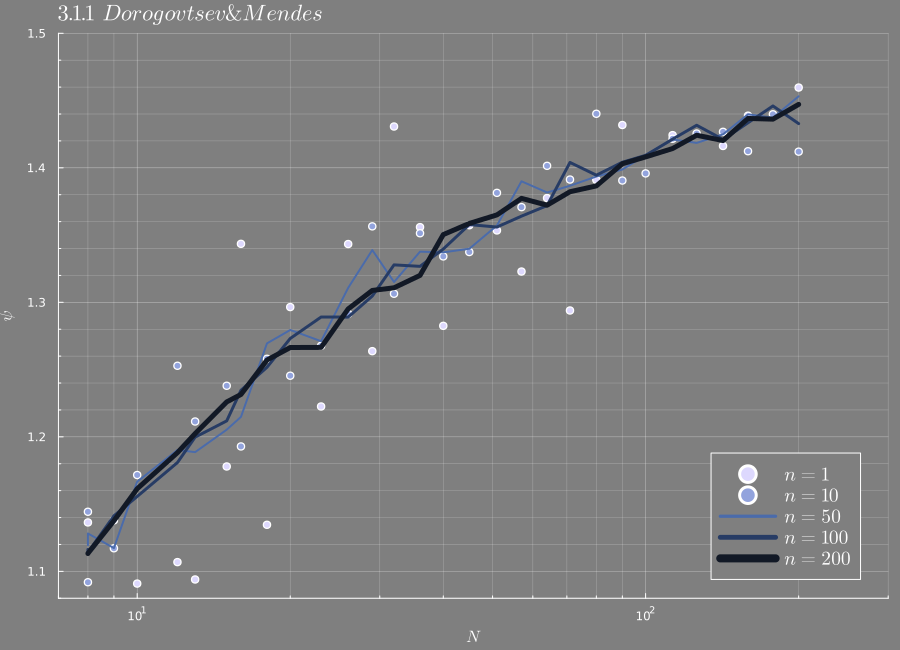

In [115]:
p1 = scatter(nspace_dm, dmt1,
    title = L"3.1.1\ Dorogovtsev&Mendes",
    titlepos = :left,
    titlefontsize = 15,
    legend = :bottomright,
    legendfontsize = 13,
    label = L"n = 1",
    size = (900, 650),
    xaxis = (L"N", :log),
    xlims = (7, 300),
    
    yaxis = L"\psi",
    ylims = (1.08, 1.5),
    linewidth = 8,
    background_color = :grey50,
    palette = :tofino10,
    
    minorgrid = true,
    minorgridalpha = 0.3,
    gridalpha = 0.5,
    )
scatter!(nspace_dm, dmt2, label = L"n = 10", linewidth = 1)
plot!(   nspace_dm, dmt3, label = L"n = 50", linewidth = 2)
plot!(   nspace_dm, dmt4, label = L"n = 100",linewidth = 3)
plot!(   nspace_dm, dmt5, label = L"n = 200",linewidth = 5)

Условные обозначения здесь и ниже:
* $\Large\psi$ -- искомая метрика
* $\large N$ -- количество вершин в графе
* $\large n$ -- количество запусков алгоритма для усреднения
* $\large p$ -- вероятность в модели Эрдёша-Реньи
* $\large k$ -- степень вершин в регулярном графе

In [131]:
savefig(p1, "plots/DorogovtsevMendes_1.svg");

In [20]:
nspace_dm_ext = logspace(Int, 2, 10, 30, 2);
dmt6 = d_m_tests(nspace_dm_ext, 40);

Progress: 100%|█████████████████████████████████████████| Time: 0:06:07


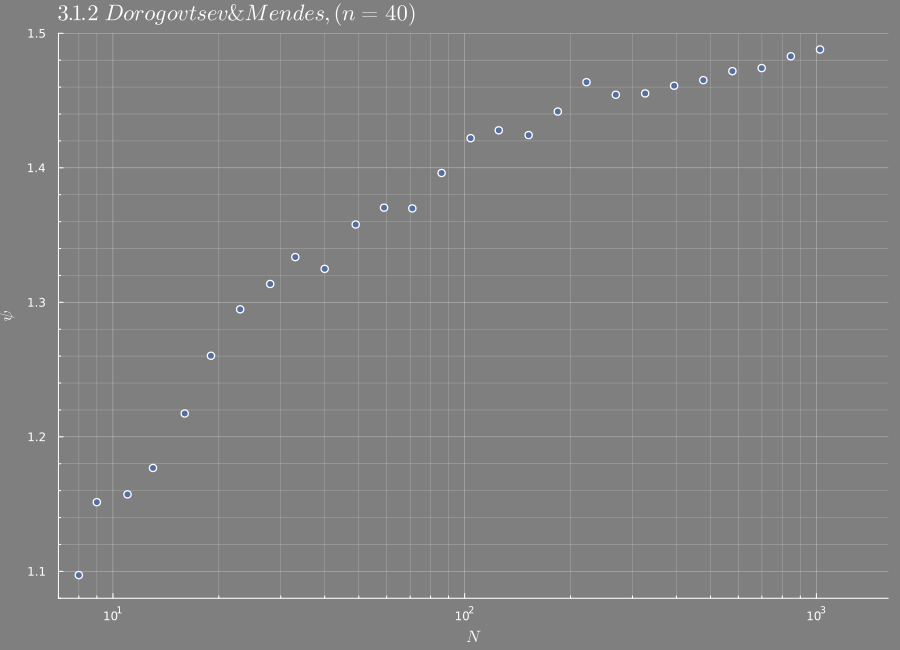

In [114]:
# theme(:vibrant)
p2 = scatter(nspace_dm_ext, dmt6,
    title = L"3.1.2\ Dorogovtsev & Mendes, (n = 40)",
    titlepos = :left,
    titlefontsize = 15,
    legend = false,
    size = (900, 650),
    xaxis = (L"N", :log10),
    xlims = (7, 1.6e3),
    
    yaxis = L"\psi",
    ylims = (1.08, 1.5),
    linewidth =8,
    background_color = :grey50,
    color = "#546ea1",
    
    minorgrid = true,
    minorgridalpha = 0.3,
    gridalpha = 0.5,
)

In [130]:
savefig(p2, "plots/DorogovtsevMendes_2.svg");

### 3.2 [Erdős-Rényi<base target="_blank">](https://en.wikipedia.org/wiki/Erd%C5%91s%E2%80%93R%C3%A9nyi_model)

[К содержанию](#Содержание:)

Этот алгоритм создаёт `n` вершин и пробрасывает между всеми парами установленную вероятность `p` чтобы соединить их ребром.

Посмотрим на его работу:

In [23]:
erPlot(g) = gplot(g, nodefillc = "Orange", edgestrokec = "darkgray");

ψᵢ_sum(er1) = 1.0
  0.000142 seconds (197 allocations: 11.805 KiB)


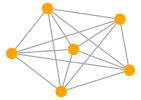

In [24]:
er1 = erdos_renyi(6, 1.0)
@time @show ψᵢ_sum(er1)
erPlot(er1)

ψᵢ_sum(er2) = 1.0
  0.000114 seconds (198 allocations: 12.102 KiB)


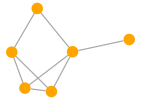

In [25]:
er2 = erdos_renyi(6, 0.5)
@time @show ψᵢ_sum(er2)
erPlot(er2)

ψᵢ_sum(er3) = 2.114903714520398
  0.015111 seconds (39.70 k allocations: 9.211 MiB)


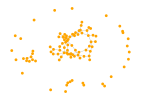

In [62]:
er3 = erdos_renyi(100, 0.02)
@time @show ψᵢ_sum(er3)
erPlot(er3)

ψᵢ_sum(er4) = 2.0116263998340935
  0.200637 seconds (310.57 k allocations: 173.384 MiB, 22.06% gc time)


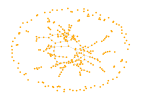

In [67]:
er4 = erdos_renyi(300, 0.005)
@time @show ψᵢ_sum(er4)
erPlot(er4)

In [28]:
function e_r_tests(nspace, repeats, p)
    n = length(nspace)
    results = zeros(n)
    progress = Progress(n+1, 1)
    next!(progress)
    for i in n:-1:1
        av = zeros(Float32, repeats)
        Threads.@threads for j = 1:repeats
            g = erdos_renyi(nspace[i], p)
            av[j] = ψᵢ_sum(g)
        end
        results[i] = ThreadsX.sum(av)/repeats
        next!(progress)
    end
    return results
end;

In [119]:
repeats_er = 200
nspace_er = 3:5:200
ert0 = e_r_tests(nspace_er, repeats_er, 0.01)
ert1 = e_r_tests(nspace_er, repeats_er, 0.02)
ert2 = e_r_tests(nspace_er, repeats_er, 0.05)
ert3 = e_r_tests(nspace_er, repeats_er, 0.1)
ert4 = e_r_tests(nspace_er, repeats_er, 0.2)
ert5 = e_r_tests(nspace_er, repeats_er, 0.3);

Progress: 100%|█████████████████████████████████████████| Time: 0:01:00
Progress: 100%|█████████████████████████████████████████| Time: 0:01:55
Progress: 100%|█████████████████████████████████████████| Time: 0:02:24
Progress: 100%|█████████████████████████████████████████| Time: 0:02:38
Progress: 100%|█████████████████████████████████████████| Time: 0:03:06
Progress: 100%|█████████████████████████████████████████| Time: 0:03:33


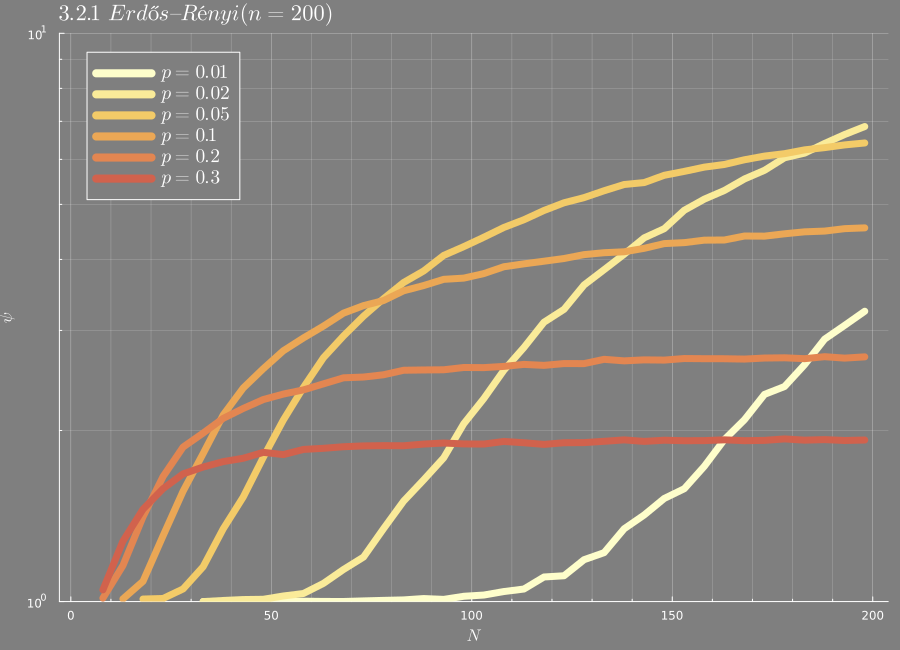

In [120]:
p3 = plot(nspace_er, ert0,
    title = L"3.2.1\ Erdős–Rényi (n = 200)",
    titlepos = :left,
    titlefontsize = 15,
    legend = :topleft,
    legendfontsize = 13,
    label = L"p = 0.01",
    size = (900, 650),
    xaxis = L"N",
    ylims = (1, 10),
    yaxis = (L"\psi", :log),
    linewidth = 7,
    minorgrid = true,
    minorgridalpha = 0.3,
    gridalpha = 0.5,

    palette = :lajolla10,
    background_color = :grey50
    )

plot!(nspace_er, ert1, label = L"p = 0.02",linewidth = 7)
plot!(nspace_er, ert2, label = L"p = 0.05",linewidth = 7)
plot!(nspace_er, ert3, label = L"p = 0.1",linewidth = 7)
plot!(nspace_er, ert4, label = L"p = 0.2",linewidth = 7)
plot!(nspace_er, ert5, label = L"p = 0.3",linewidth = 7)

In [129]:
savefig(p3, "plots/ErdosRenyi_1.svg");

In [32]:
function e_r_tests_prob(nspace, repeats, pspace)
    n = length(pspace)
    results = zeros(n)
    progress = Progress(n+1, 1)
    next!(progress)
    for p in n:-1:1
        av = zeros(Float32, repeats)
        Threads.@threads for j = 1:repeats
            g = erdos_renyi(nspace, pspace[p])
            av[j] = ψᵢ_sum(g)
        end
        results[p] = ThreadsX.sum(av)/repeats
        next!(progress)
    end
    return results
end;

In [107]:
repeats = 50
pspace_er = logspace(-2.5, 0, 100)

ert6 = e_r_tests_prob(50, repeats, pspace_er)
ert7 = e_r_tests_prob(75, repeats, pspace_er)
ert8 = e_r_tests_prob(100, repeats, pspace_er)
ert9 = e_r_tests_prob(125, repeats, pspace_er)
ert10 = e_r_tests_prob(150, repeats, pspace_er);
ert11 = e_r_tests_prob(200, repeats, pspace_er);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21
Progress: 100%|█████████████████████████████████████████| Time: 0:00:48
Progress: 100%|█████████████████████████████████████████| Time: 0:01:32
Progress: 100%|█████████████████████████████████████████| Time: 0:02:39
Progress: 100%|█████████████████████████████████████████| Time: 0:07:00


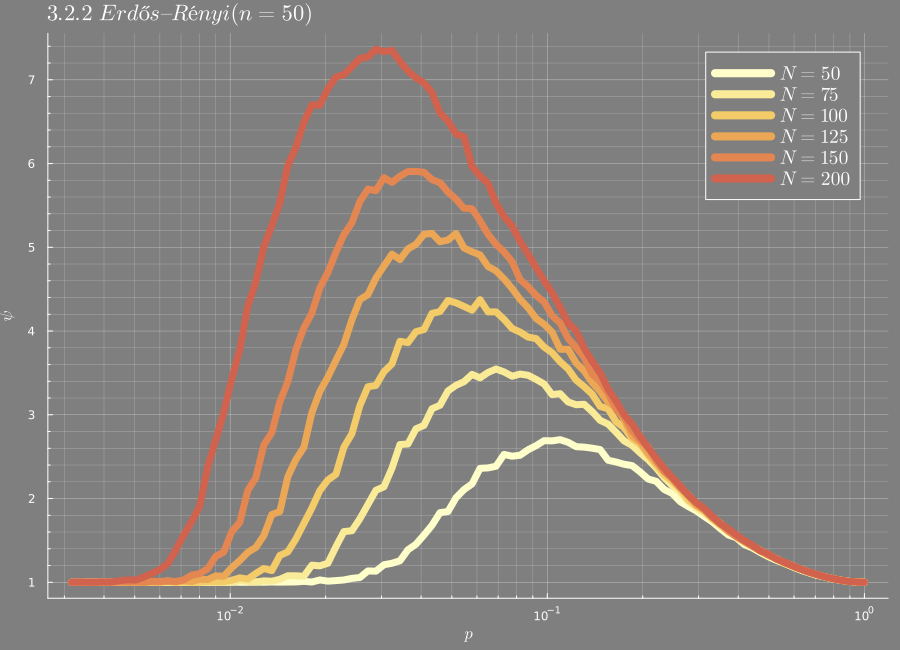

In [132]:
p4 = plot(pspace_er, ert6,
    title = L"3.2.2\ Erdős–Rényi (n = 50)",
    titlepos = :left,
    titlefontsize = 15,
    legend = :topright,
    legendfontsize = 13,
    label = L"N = 50",
    size = (900, 650),
    xaxis = (L"p", :log),
    yaxis = L"\psi",
    linewidth = 7,
    minorgrid = true,
    minorgridalpha = 0.3,
    gridalpha = 0.5,
    palette = :lajolla10,
    background_color = :grey50
    )

plot!(pspace_er, ert7, label = L"N = 75",linewidth = 7)
plot!(pspace_er, ert8, label = L"N = 100",linewidth = 7)
plot!(pspace_er, ert9, label = L"N = 125",linewidth = 7)
plot!(pspace_er, ert10, label = L"N = 150",linewidth = 7)
plot!(pspace_er, ert11, label = L"N = 200",linewidth = 7)

In [133]:
savefig(p4, "plots/ErdosRenyi_2.svg");

Видим, что не все сгенерированные графы оказались полносвязными. Именно для этого случая в нашей функции есть фильтрация расстояний между вершинами разных компонент связности.

### 3.3 [Регулярный граф<base target="_blank">](https://en.wikipedia.org/wiki/Regular_graph)

[К содержанию](#Содержание:)

Случайный, с одинаковой степенью каждой вершины. Может оказаться не односвязным.

In [36]:
rgPlot(g) = gplot(g, nodefillc = "#c368ab", edgestrokec = "darkgray");

ψᵢ_sum(rg1) = 1.5053191489361701
  0.000333 seconds (1.35 k allocations: 119.766 KiB)


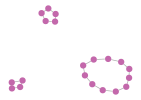

In [68]:
rg1 = random_regular_graph(20, 2)
@time @show ψᵢ_sum(rg1)
rgPlot(rg1)

ψᵢ_sum(rg2) = 1.2912621359223302
  0.000180 seconds (776 allocations: 76.359 KiB)


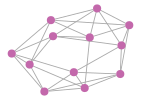

In [38]:
rg2 = random_regular_graph(12, 5)
@time @show ψᵢ_sum(rg2)
rgPlot(rg2)

ψᵢ_sum(rg3) = 3.0358214928957374
  0.003688 seconds (14.51 k allocations: 2.441 MiB)


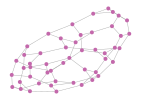

In [39]:
rg3 = random_regular_graph(50, 3)
@time @show ψᵢ_sum(rg3)
rgPlot(rg3)

ψᵢ_sum(rg4) = 1.2214285714285715
  0.000688 seconds (2.33 k allocations: 298.406 KiB)


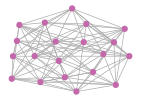

In [74]:
rg4 = random_regular_graph(20, 10)
@time @show ψᵢ_sum(rg4)
rgPlot(rg4)

In [41]:
function r_g_tests(nspace, repeats, k)
    n = length(nspace)
    results = zeros(n)
    progress = Progress(n+1, 1)
    next!(progress)
    for i in n:-1:1
        av = zeros(Float32, repeats)
        Threads.@threads for j = 1:repeats
            g = random_regular_graph(nspace[i], k)
            av[j] = ψᵢ_sum(g)
        end
        results[i] = ThreadsX.sum(av)/repeats
        next!(progress)
    end
    return results
end;

In [42]:
repeats = 20
nspace_rg1 = 3:2:200
nspace_rg2 = 4:2:200
nspace_rg3 = 5:2:200


rgt1 = r_g_tests(nspace_rg1, repeats, 2)
rgt2 = r_g_tests(nspace_rg2, repeats, 3)
rgt3 = r_g_tests(nspace_rg3, repeats, 4);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:16
Progress: 100%|█████████████████████████████████████████| Time: 0:00:30
Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


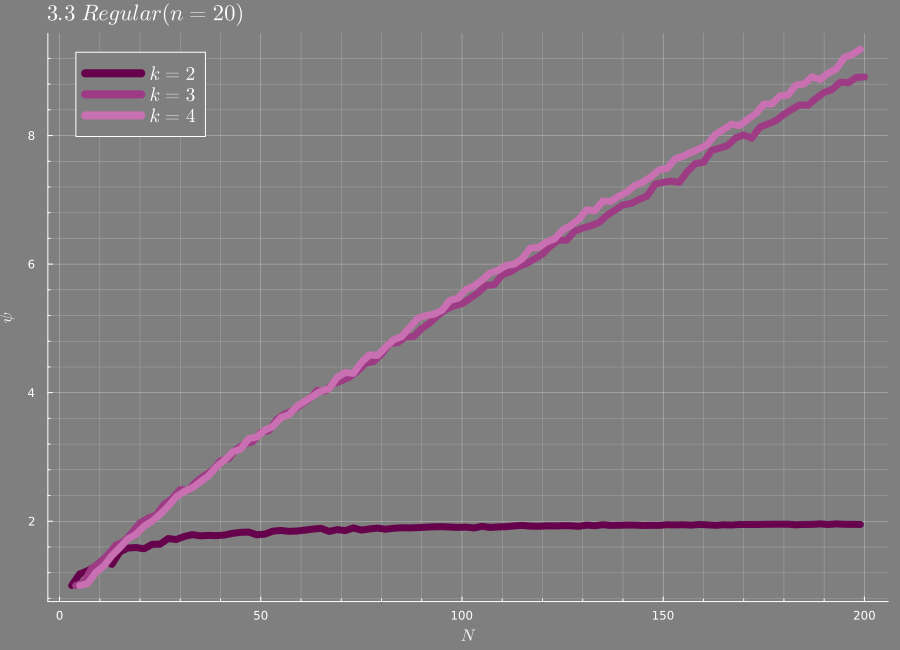

In [118]:
p5 = plot(nspace_rg1, rgt1,
    title = L"3.3\ Regular (n = 20)",
    titlepos = :left,
    titlefontsize = 15,
    legend = :topleft,
    legendfontsize = 13,
    label = L"k = 2",
    size = (900, 650),
    xaxis = L"N",
    yaxis = L"\psi",
    linewidth = 7,
    minorgrid = true,
    minorgridalpha = 0.3,
    gridalpha = 0.5,
    palette = :bam10,
    background_color = :grey50
    )

plot!(nspace_rg2, rgt2, label = L"k = 3",linewidth = 7)
plot!(nspace_rg3, rgt3, label = L"k = 4",linewidth = 7)

In [126]:
savefig(p5, "plots/Regular.svg");

Я упускаю много ещё разновидностей графов, но не могу обойти стороной деревья.
### 3.4 [Однородные (uniform) деревья  <base target="_blank">](https://en.wikipedia.org/wiki/Uniform_tree)

[К содержанию](#Содержание:)

Для деревьев средняя эффективность алгоритмов поиска одинаковая, так что ниже графиков нет. 

In [45]:
utPlot(g) = gplot(g, nodefillc = RGB(0.3,0.85,0.3), edgestrokec = "darkgray");

ψᵢ_sum(t1) = 1.0
  0.001050 seconds (4.59 k allocations: 527.633 KiB)


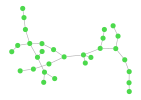

In [75]:
t1 = uniform_tree(30)
@time @show ψᵢ_sum(t1)
utPlot(t1)

ψᵢ_sum(t2) = 1.0
  0.197788 seconds (233.29 k allocations: 89.923 MiB, 16.62% gc time)


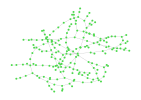

In [77]:
t2 = uniform_tree(200)
@time @show ψᵢ_sum(t2)
utPlot(t2)

### 3.5 Бинарные деревья

[К содержанию](#Содержание:)

In [48]:
btPlot(g) = gplot(g, nodefillc = RGB(0.6,0.7,0.6), edgestrokec = "darkgray");

ψᵢ_sum(bt1) = 1.0
  0.000236 seconds (1.13 k allocations: 98.289 KiB)


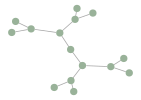

In [49]:
bt1 = binary_tree(4)
@time @show ψᵢ_sum(bt1)
btPlot(bt1)

ψᵢ_sum(bt2) = 1.0
  0.006689 seconds (21.59 k allocations: 3.827 MiB)


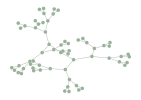

In [50]:
bt2 = binary_tree(6)
@time @show ψᵢ_sum(bt2)
btPlot(bt2)

---
# 4. Заключение

[К содержанию](#Содержание:)

Подход к подтверждению/опревержению гипотезы о том, что поиск в ширину в среднем вдвое эффективнее поиска в глубину для неорентированных графов зависит от выбранного способа этот граф создать. Как можно видеть из примеров, её выполнение зависит от установленных параметров генерации. 
* Метод Дороговцева Мендеса — $\large\psi$ приближается скорее к $1.5$
* Модель Модель Эрдёша-Реньи — $\large\psi$ зависит от выбора параметров
* Регулярные графы — гипотеза подтвердилась при степени вершин $k=2$
* Однородные и бинарные деревья - гипотеза не выполняется (примечание: оба алгоритма поиска в среднем показывают себя одинаково при любом количестве вершин).